In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
model = model.to(device)
model.eval()
print(f"Model loaded on: {device}")

/home/chojecki/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
Using cache found in /home/chojecki/.cache/torch/hub/facebookresearch_dinov2_main
/home/chojecki/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/chojecki/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/chojecki/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is av

Model loaded on: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

def get_embedding(image_path):
    """Get normalized embedding for an image."""
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        embedding = model(img_tensor)
    return F.normalize(embedding, p=2, dim=-1)

def cosine_sim(emb1, emb2):
    """Compute cosine similarity."""
    return torch.mm(emb1, emb2.t()).item()

In [ ]:
IMAGE_DIR = "test"
image_paths = sorted([
    os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

print(f"Found {len(image_paths)} images:")
for p in image_paths:
    print(f"  - {p}")

Found 5 images:
  - test/4533.jpeg
  - test/4624.jpeg
  - test/Red_Apple.jpg
  - test/c0231715-800px-wm.jpg
  - test/e7800943-800px-wm.jpg


In [ ]:
embeddings = {}
for path in image_paths:
    embeddings[path] = get_embedding(path)
    print(f"Computed embedding for: {os.path.basename(path)}")

Computed embedding for: 4533.jpeg
Computed embedding for: 4624.jpeg
Computed embedding for: Red_Apple.jpg
Computed embedding for: c0231715-800px-wm.jpg
Computed embedding for: e7800943-800px-wm.jpg


In [ ]:
pairs = []
for i, img1 in enumerate(image_paths):
    for j, img2 in enumerate(image_paths):
        if i < j:
            sim = cosine_sim(embeddings[img1], embeddings[img2])
            pairs.append((img1, img2, sim))

pairs.sort(key=lambda x: x[2], reverse=True)
print(f"Total pairs: {len(pairs)}")

Total pairs: 10


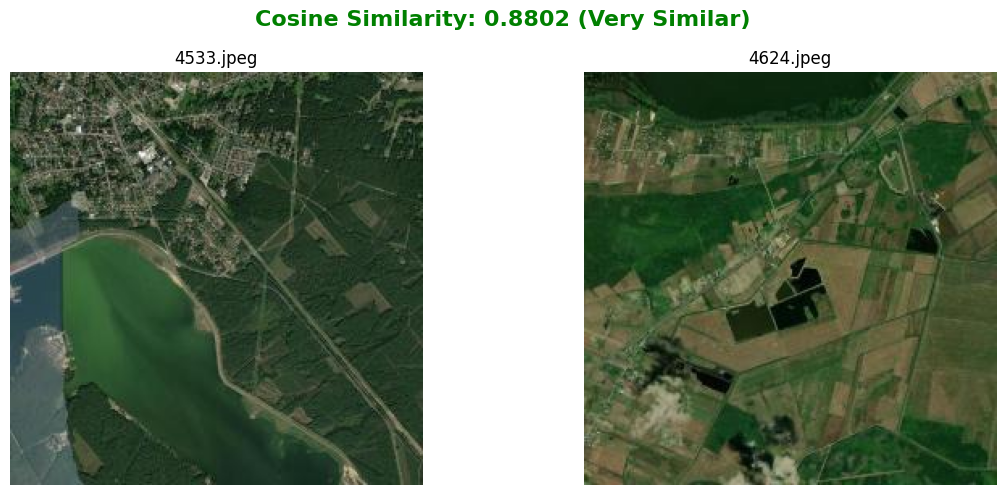

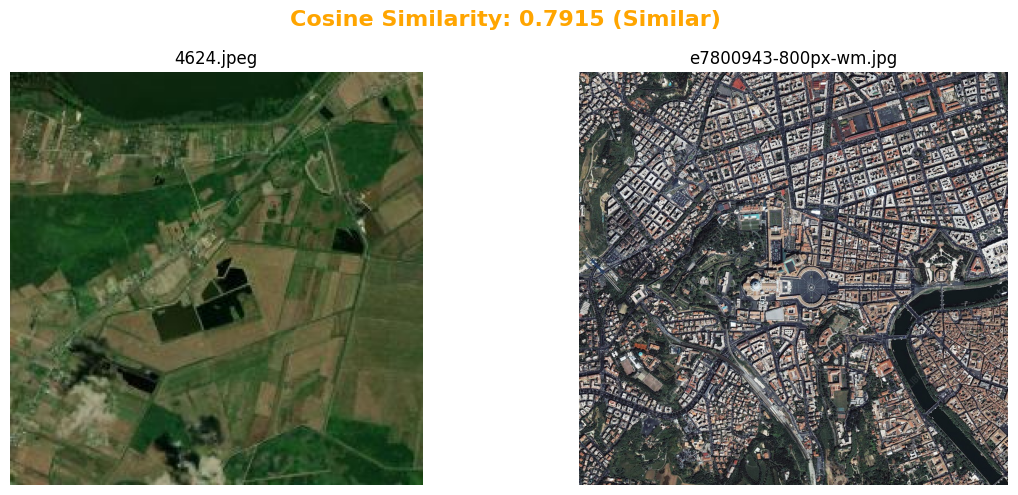

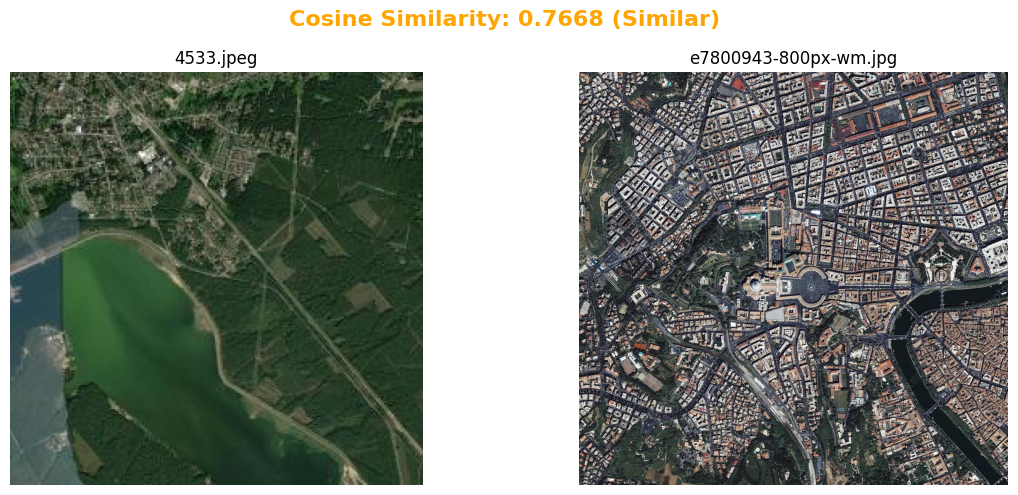

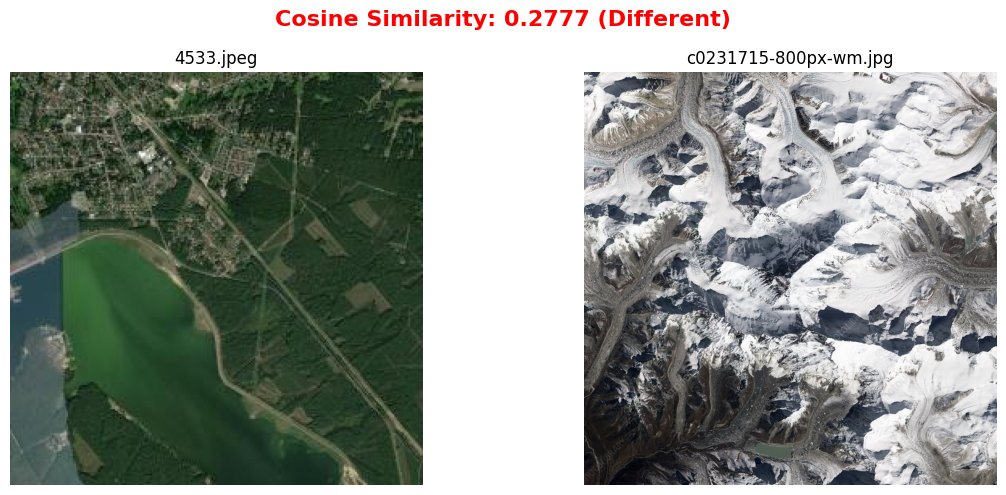

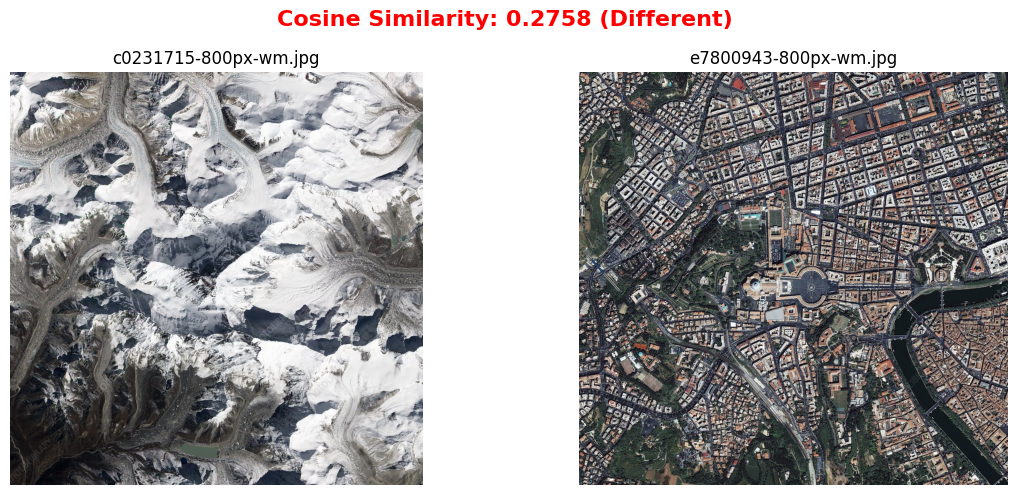

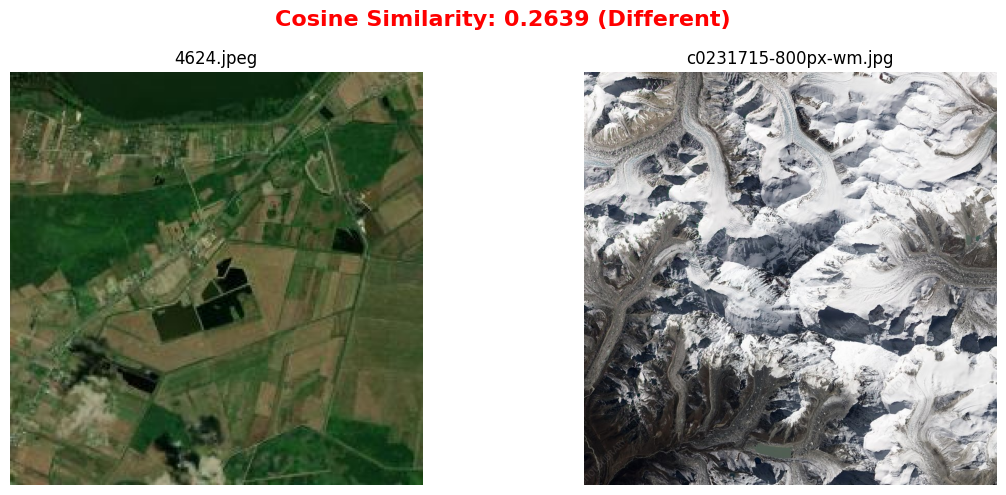

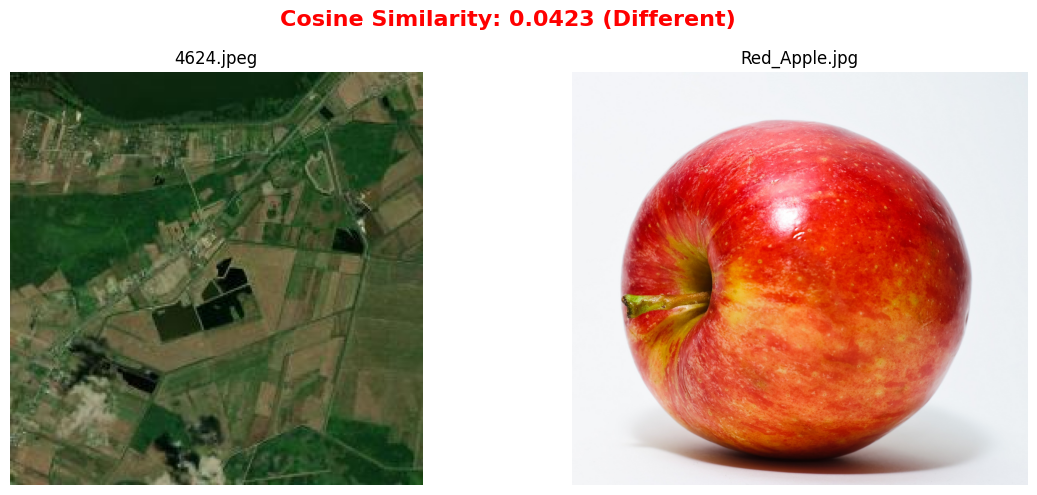

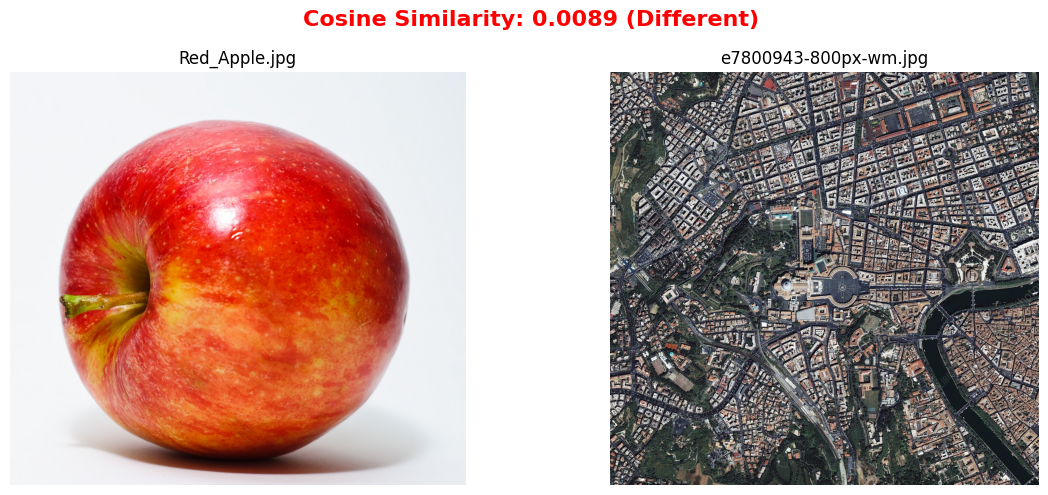

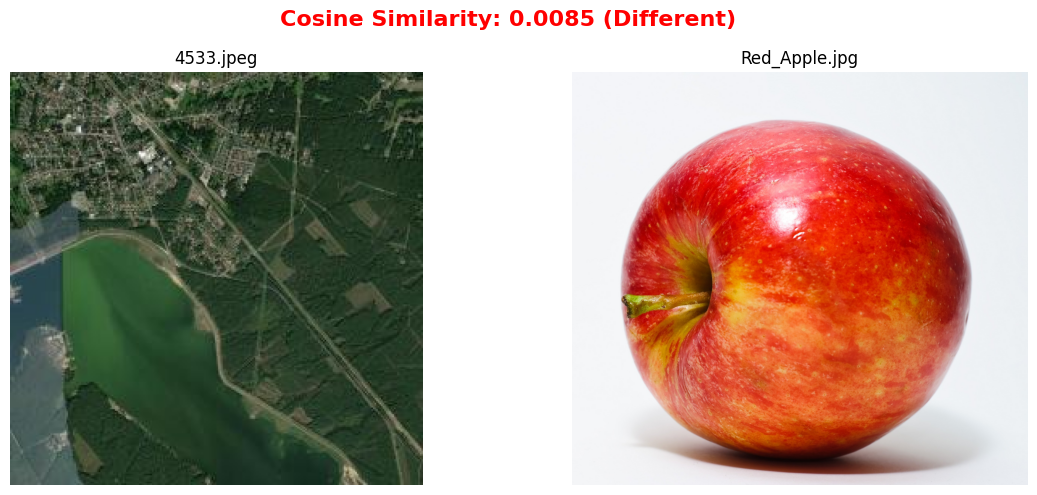

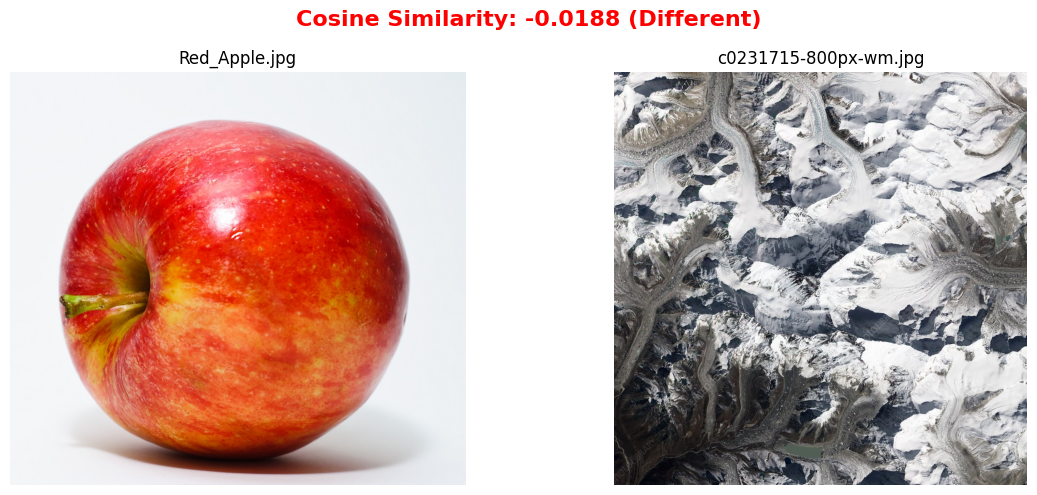

In [ ]:
for img1_path, img2_path, score in pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    
    axes[0].imshow(img1)
    axes[0].set_title(os.path.basename(img1_path), fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(img2)
    axes[1].set_title(os.path.basename(img2_path), fontsize=12)
    axes[1].axis('off')
    
    if score >= 0.8:
        color = 'green'
        label = 'Very Similar'
    elif score >= 0.5:
        color = 'orange'
        label = 'Similar'
    else:
        color = 'red'
        label = 'Different'
    
    fig.suptitle(f'Cosine Similarity: {score:.4f} ({label})', fontsize=16, color=color, fontweight='bold')
    plt.tight_layout()
    plt.show()